# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# Load libraries

import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

In [2]:
# Load data and resample it by one hour

df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [3]:
# Examine the df dataframe

display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


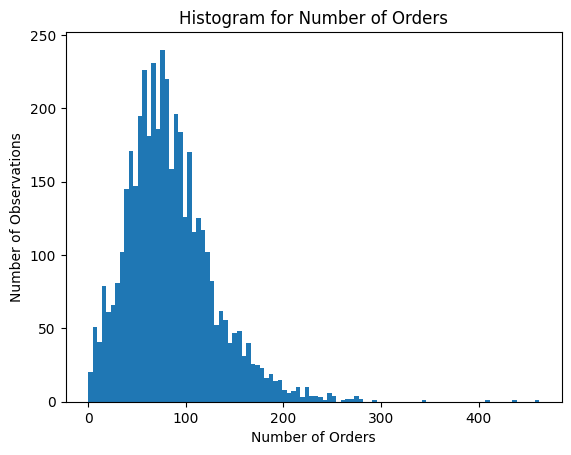

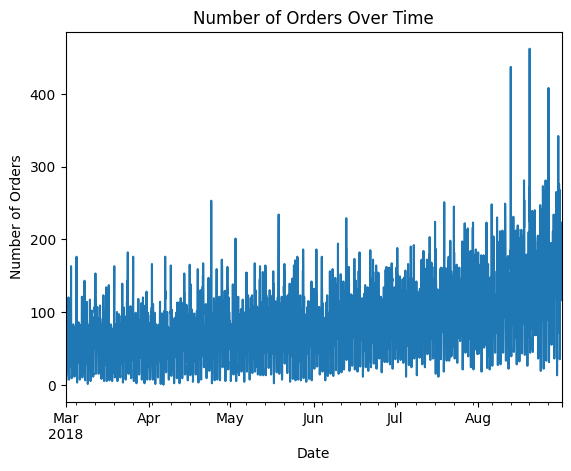

In [4]:
# Examine and plot the num_orders column

display(df.describe())

plt.hist(df, bins=100)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Observations')
plt.title(f'Histogram for Number of Orders')
plt.show()

df['num_orders'].plot()
plt.title("Number of Orders Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

In [5]:
# Examine outliers in the num_orders column

outlier_cutoff = df['num_orders'].quantile(0.75)+1.5*(df['num_orders'].quantile(0.75) - df['num_orders'].quantile(0.25))
outliers = (df['num_orders'] > outlier_cutoff).sum()
print(f"Outliers: {outliers} ({100*outliers/len(df):.2f}%)")
print(f"Most extreme value: {df['num_orders'].max()}, {(df['num_orders'].max()-df['num_orders'].mean())/df['num_orders'].std():.2f} SDs above the Mean")

Outliers: 121 (2.74%)
Most extreme value: 462, 8.39 SDs above the Mean


The data look good overall. I parsed the datetime column as datetime64[ns], assigned it as the index, and resampled it by one hour. The data run continuously from 2018-03-01 to 2018-08-31 (inclusive) with no missing values. The num_orders column contains integer data approximately normal in shape though moderately right skewed. It does have a relatively long right tail with 121 outliers (2.74% of the dataset) according to the interquartile rule and a maximum value of 462, which is more than 8 standard deviations above the mean. Those outliers could be problematic, but they are rare and not out of place in the distribution, so I will ignore them. 

## Analysis

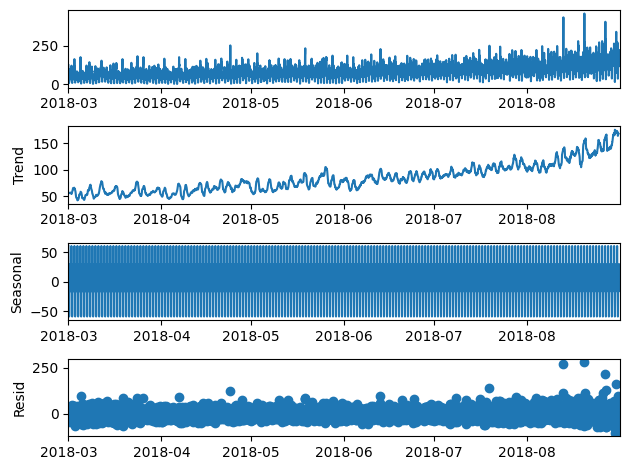

In [6]:
# Decompose the time series into trend, seasonality, and residual components

decomposition = seasonal_decompose(df)
decomposition.plot()
plt.show()

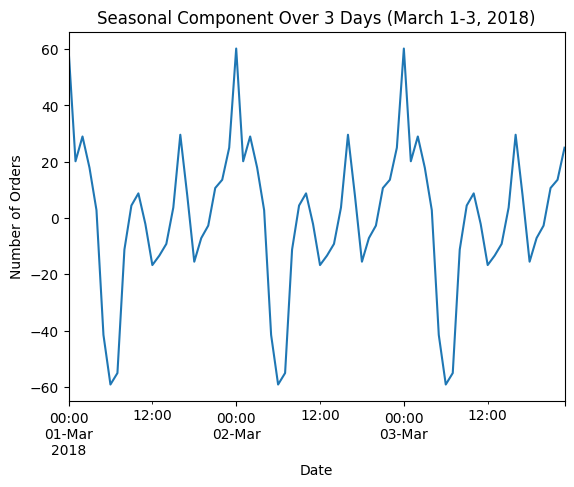

In [7]:
# Examine the seasonal component

decomposition.seasonal['2018-03-01':'2018-03-3'].plot()
plt.title("Seasonal Component Over 3 Days (March 1-3, 2018)")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

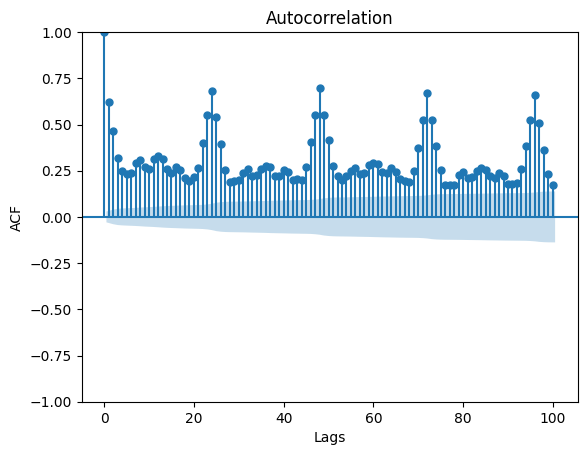

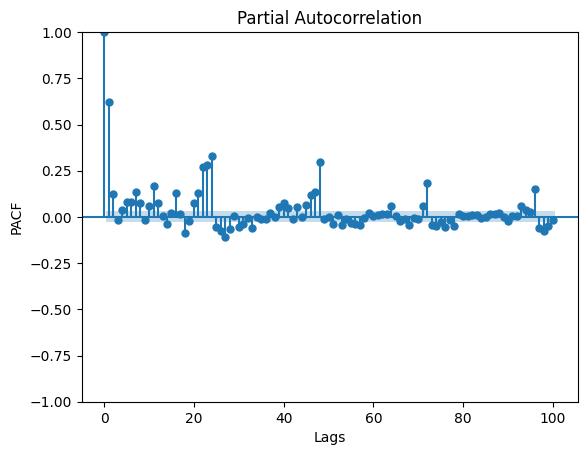

In [8]:
# Plot autocorrelations and partial autocorrelations

plot_acf(x=df, lags=100)
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.show()

plot_pacf(x=df, lags=100)
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

In [9]:
# Test stationarity with the Dickey-Fuller unit root test

df_stationarityTest = adfuller(df, autolag='AIC')

print("Dickey-Fuller Unit Root Test")
print("P-value: ", df_stationarityTest[1])

Dickey-Fuller Unit Root Test
P-value:  0.028940051402613028


The data show a modestly increasing trend and a recurring seasonal component at the scale of one day. They also have high autocorrelations and partial autocorrelations at lag intervals of 24 steps (one day). According to the Dickey-Fuller unit root test, the time series is stationary (p < 0.05). 

## Training

In [10]:
# Create functions to help make features and tune regression models

def make_features(original_data, max_lag, rolling_mean_size):
    data = original_data.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

def tune_predictors(original_data, model, max_lags, roll_sizes):
    for roll in roll_sizes:
        for lag in max_lags:
            data = make_features(original_data, lag, roll)
            data = data.dropna()
            train, valid = train_test_split(data, shuffle=False, test_size=0.1)

            features_train = train.drop('num_orders', axis=1)
            features_valid = valid.drop('num_orders', axis=1)
            target_train = train['num_orders']
            target_valid = valid['num_orders']

            model.fit(features_train, target_train)
            predict_train = pd.Series(model.predict(features_train))
            predict_valid = pd.Series(model.predict(features_valid))
            rmse_train = mean_squared_error(target_train, predict_train) ** 0.5
            rmse_valid = mean_squared_error(target_valid, predict_valid) ** 0.5
            
            print(f"Lag = {lag}, Roll Size = {roll}, Training RMSE = {rmse_train:.02f}, Validation RMSE = {rmse_valid:.02f}") 

def find_top_features(original_data, model, max_lag, rolling_mean_size):
    data = make_features(original_data, max_lag, rolling_mean_size)
    data = data.dropna()
    train, valid = train_test_split(data, shuffle=False, test_size=0.1)

    features_train = train.drop('num_orders', axis=1)
    features_valid = valid.drop('num_orders', axis=1)
    target_train = train['num_orders']
    target_valid = valid['num_orders']

    model.fit(features_train, target_train)
    predict_train = pd.Series(model.predict(features_train))
    predict_valid = pd.Series(model.predict(features_valid))
    rmse_train = mean_squared_error(target_train, predict_train) ** 0.5
    rmse_valid = mean_squared_error(target_valid, predict_valid) ** 0.5

    if isinstance(model, LinearRegression):
        top_features = pd.Series(np.abs(model.coef_), index=features_train.columns).sort_values(ascending=False).head(30)
    elif isinstance(model, RandomForestRegressor):
        top_features = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False).head(30)

    print('Model Results:')
    print(f"Training RMSE = {rmse_train:.02f}, Validation RMSE = {rmse_valid:.02f}") 
    print()
    print('Feature Importance:')
    print(top_features)
    
    return top_features

def plot_hyperparam_search(results, params):
    results_df = pd.DataFrame(results)
    results_df = results_df[[f"param_{x}" for x in params] + ['mean_test_score']]
    results_df['mean_test_score'] = -results_df['mean_test_score']

    i = 0
    plt.figure(figsize=(12, 5))
    for param in params:
        i += 1
        plt.subplot(1, 3, i)
        results_df.groupby(f"param_{param}")['mean_test_score'].mean().plot(marker='o')
        plt.xlabel(param)
        plt.ylabel("Average RMSE")
        plt.title(f"Average RMSE by {param}")

    plt.tight_layout()
    plt.show()
    
    return results_df.sort_values(by='mean_test_score')

In [11]:
# Split the data into training and test sets

df_train, df_test = train_test_split(df, shuffle=False, test_size=0.1)

print(f"Training set size: {len(df_train)}, {100*len(df_train)/len(df):.0f}%")
print(f"Test set size: {len(df_test)}, {100*len(df_test)/len(df):.0f}%")

Training set size: 3974, 90%
Test set size: 442, 10%


In [12]:
# Optimize lag number and rolling average window size for linear regression

print('Linear Regression Results:')
tune_predictors(df_train, LinearRegression(), [1,6,12,24,48,72,96,120,240,480], [1,12,24])

Linear Regression Results:
Lag = 1, Roll Size = 1, Training RMSE = 29.33, Validation RMSE = 41.13
Lag = 6, Roll Size = 1, Training RMSE = 29.15, Validation RMSE = 40.67
Lag = 12, Roll Size = 1, Training RMSE = 28.77, Validation RMSE = 40.25
Lag = 24, Roll Size = 1, Training RMSE = 24.60, Validation RMSE = 34.15
Lag = 48, Roll Size = 1, Training RMSE = 22.34, Validation RMSE = 31.25
Lag = 72, Roll Size = 1, Training RMSE = 21.66, Validation RMSE = 30.12
Lag = 96, Roll Size = 1, Training RMSE = 21.32, Validation RMSE = 29.68
Lag = 120, Roll Size = 1, Training RMSE = 20.87, Validation RMSE = 29.20
Lag = 240, Roll Size = 1, Training RMSE = 19.05, Validation RMSE = 28.51
Lag = 480, Roll Size = 1, Training RMSE = 18.25, Validation RMSE = 29.25
Lag = 1, Roll Size = 12, Training RMSE = 29.37, Validation RMSE = 40.90
Lag = 6, Roll Size = 12, Training RMSE = 29.16, Validation RMSE = 40.65
Lag = 12, Roll Size = 12, Training RMSE = 28.77, Validation RMSE = 40.25
Lag = 24, Roll Size = 12, Training 

In [13]:
# Find the most predictive features for linear regression

top_features = find_top_features(df_train, LinearRegression(), 240, 1)

Model Results:
Training RMSE = 19.05, Validation RMSE = 28.51

Feature Importance:
month        4.773949
dayofweek    0.399921
lag_168      0.326728
day          0.275085
hour         0.113896
lag_48       0.111102
lag_24       0.099455
lag_72       0.092230
lag_120      0.078850
lag_7        0.078706
lag_96       0.077666
lag_2        0.071421
lag_191      0.068717
lag_70       0.061184
lag_167      0.061122
lag_169      0.058150
lag_13       0.055689
lag_43       0.052207
lag_12       0.049086
lag_8        0.046908
lag_56       0.046444
lag_159      0.043618
lag_216      0.043579
lag_4        0.041592
lag_11       0.040150
lag_5        0.039806
lag_197      0.039407
lag_162      0.038515
lag_14       0.038116
lag_183      0.037923
dtype: float64


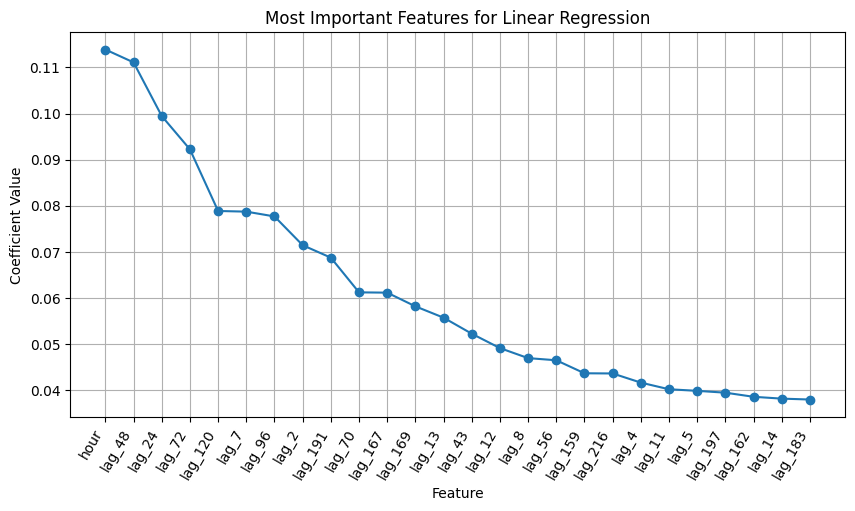

In [14]:
# Plot the most important features (without the first few to keep the scale legible) for linear regression

top_features_plot = top_features[4:].copy()
plt.figure(figsize=(10, 5))
plt.plot(top_features_plot.index, top_features_plot.values, marker='o')
plt.xticks(rotation=60, ha='right')
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.title("Most Important Features for Linear Regression")
plt.grid(True)
plt.show()

In [15]:
# Run the linear regression model with only the most important features

retained_features_LR = ['num_orders'] + top_features[top_features > 0.06].index.tolist()
data = make_features(df_train, 240, 1)
data = data[retained_features_LR]

data = data.dropna()
train, valid = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
features_valid = valid.drop('num_orders', axis=1)
target_train = train['num_orders']
target_valid = valid['num_orders']

model = LinearRegression()
model.fit(features_train, target_train)
predict_train = pd.Series(model.predict(features_train))
predict_valid = pd.Series(model.predict(features_valid))
rmse_train = mean_squared_error(target_train, predict_train) ** 0.5
rmse_valid = mean_squared_error(target_valid, predict_valid) ** 0.5

print(f"Training RMSE = {rmse_train:.02f}, Validation RMSE = {rmse_valid:.02f}")
print('Number of features =', features_train.shape[1])

Training RMSE = 20.34, Validation RMSE = 29.01
Number of features = 15


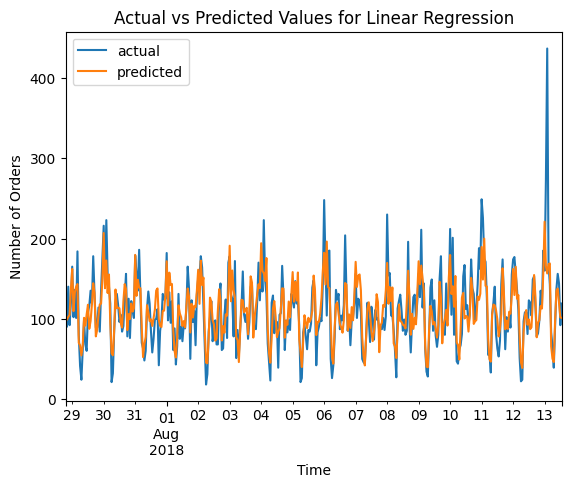

In [16]:
# Plot actual vs. predicted values for linear regression

predict_valid = pd.Series(model.predict(features_valid), index=target_valid.index)
plot_data = pd.DataFrame({'actual': target_valid, 'predicted': predict_valid})

plot_data.plot()
plt.title("Actual vs Predicted Values for Linear Regression")
plt.xlabel("Time")
plt.ylabel("Number of Orders")
plt.show()

I created several features for a linear regression model including calendar features (month, day, hour, and day of the week), lag features, and rolling mean. I tried several models with different numbers of lag features and different rolling mean windows. Because the time series has a daily seasonal component (24 hours), I tried maximum lags of simple multiples and divisors of 24. The window had no effect on scores, but the best performing model had 240 lag features (RMSE = 28.51). 

That many features is unwieldy and may cause overtraining, so I pared them back. A plot of feature coefficients revealed plateaus around 0.08 and 0.06. I retained only 15 features with coefficients greater than 0.06, including month, day of week, day, hour, and various lags (at 2, 7, 24, 48, 70, 72, 96, 120, 167, 168, and 191 steps). It performed well with an RMSE of 29.01, not much worse than the full model with 240 lags. The plot of predicted vs. actual values showed that the model is quite good.

In [17]:
# Optimize lag number and rolling average window size for the random forest regressor

print('Random Forest Results:')
tune_predictors(df_train, RandomForestRegressor(random_state=12345), [24,48,72,96,120,240,480], [1,12,24])

Random Forest Results:
Lag = 24, Roll Size = 1, Training RMSE = 8.01, Validation RMSE = 32.33
Lag = 48, Roll Size = 1, Training RMSE = 8.08, Validation RMSE = 32.16
Lag = 72, Roll Size = 1, Training RMSE = 7.92, Validation RMSE = 31.00
Lag = 96, Roll Size = 1, Training RMSE = 7.96, Validation RMSE = 30.86
Lag = 120, Roll Size = 1, Training RMSE = 8.00, Validation RMSE = 30.50
Lag = 240, Roll Size = 1, Training RMSE = 7.64, Validation RMSE = 29.67
Lag = 480, Roll Size = 1, Training RMSE = 7.68, Validation RMSE = 29.70
Lag = 24, Roll Size = 12, Training RMSE = 7.97, Validation RMSE = 31.75
Lag = 48, Roll Size = 12, Training RMSE = 8.01, Validation RMSE = 32.32
Lag = 72, Roll Size = 12, Training RMSE = 7.90, Validation RMSE = 30.98
Lag = 96, Roll Size = 12, Training RMSE = 7.88, Validation RMSE = 30.69
Lag = 120, Roll Size = 12, Training RMSE = 7.95, Validation RMSE = 30.28
Lag = 240, Roll Size = 12, Training RMSE = 7.59, Validation RMSE = 29.73
Lag = 480, Roll Size = 12, Training RMSE = 

In [18]:
# Find the most predictive features for the random forest regressor

top_features = find_top_features(df_train, RandomForestRegressor(random_state=12345), 240, 24)

Model Results:
Training RMSE = 7.61, Validation RMSE = 29.48

Feature Importance:
lag_168         0.541774
lag_72          0.030791
lag_48          0.022852
lag_24          0.021618
lag_120         0.017892
lag_96          0.016538
lag_216         0.010770
lag_1           0.009019
lag_2           0.007443
hour            0.006725
rolling_mean    0.005579
lag_7           0.004020
lag_8           0.003143
lag_169         0.003038
lag_6           0.002917
lag_3           0.002892
lag_240         0.002812
lag_40          0.002741
lag_167         0.002709
lag_214         0.002544
lag_144         0.002496
lag_5           0.002372
lag_192         0.002344
lag_215         0.002298
lag_4           0.002288
lag_78          0.002206
lag_13          0.002092
lag_218         0.002075
lag_166         0.002070
lag_217         0.002059
dtype: float64


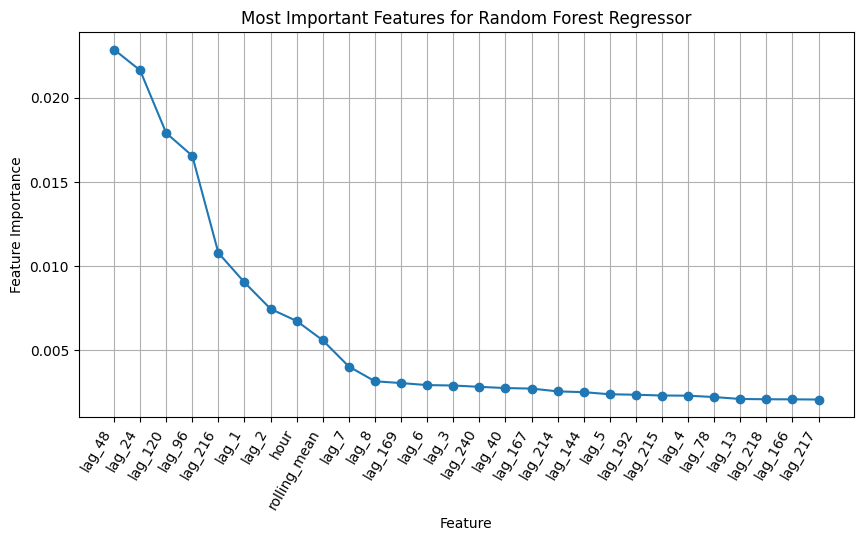

In [19]:
# Plot the most important features (without the first few to keep the scale legible) for the random forest regressor

top_features_plot = top_features[2:].copy()
plt.figure(figsize=(10, 5))
plt.plot(top_features_plot.index, top_features_plot.values, marker='o')
plt.xticks(rotation=60, ha='right')
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Most Important Features for Random Forest Regressor")
plt.grid(True)
plt.show()

In [20]:
# Run a random forest regressor model with the most important features

retained_features_RF = ['num_orders'] + top_features[top_features > 0.0031].index.tolist()

data = make_features(df_train, 240, 24)
data = data[retained_features_RF]
data = data.dropna()
train, valid = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
features_valid = valid.drop('num_orders', axis=1)
target_train = train['num_orders']
target_valid = valid['num_orders']

model = RandomForestRegressor(random_state=12345)
model.fit(features_train, target_train)

predict_train = pd.Series(model.predict(features_train))
predict_valid = pd.Series(model.predict(features_valid))
rmse_train = mean_squared_error(target_train, predict_train) ** 0.5
rmse_valid = mean_squared_error(target_valid, predict_valid) ** 0.5

print('Random Forest Regressor Model')
print(f"Training RMSE = {rmse_train:.02f}, Testing RMSE = {rmse_valid:.02f}")
print('Number of features =', features_train.shape[1])

Random Forest Regressor Model
Training RMSE = 7.65, Testing RMSE = 29.48
Number of features = 13


Best Parameters: {'n_estimators': 50, 'max_depth': 10}
Best Score (RMSE): 21.38460525362457


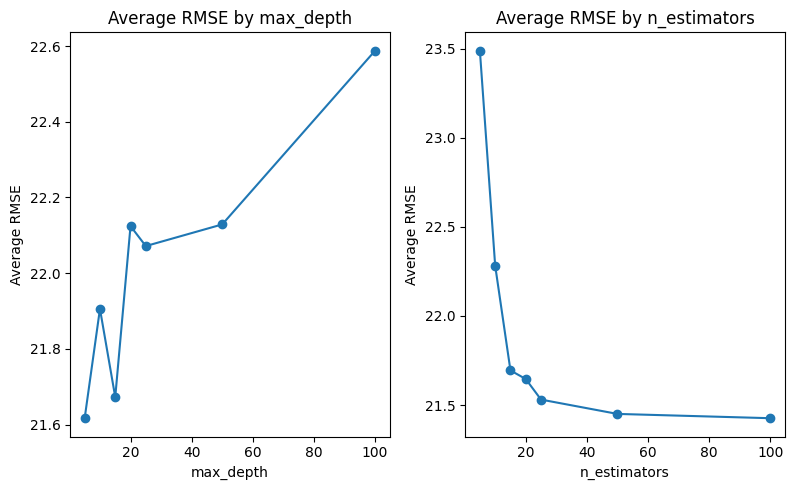

,param_max_depth,param_n_estimators,mean_test_score
2,10,50,21.384605
33,10,100,21.392884
6,15,100,21.418652
16,15,50,21.426763
15,20,50,21.448450
21,5,25,21.463453
17,5,50,21.466070
29,5,100,21.467573
34,10,25,21.471790
9,5,15,21.472153


In [21]:
# Search hyperparameters to optimize the random forest regressor model

param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'max_depth': [5, 10, 15, 20, 25, 50, 100]
}

tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor(random_state=12345)

random_search = RandomizedSearchCV(model, param_grid, random_state=12345, n_iter=35, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=1)
random_search.fit(features_train, target_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score (RMSE):", -random_search.best_score_)

plot_hyperparam_search(random_search.cv_results_, ['max_depth', 'n_estimators'])

In [22]:
# Run the random forest regressor model with optimal hyperparameters and the most important features

model = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=10)
model.fit(features_train, target_train)

predict_train = pd.Series(model.predict(features_train))
predict_valid = pd.Series(model.predict(features_valid))
rmse_train = mean_squared_error(target_train, predict_train) ** 0.5
rmse_valid = mean_squared_error(target_valid, predict_valid) ** 0.5


print('Random Forest Regressor Model')
print(f"Training RMSE = {rmse_train:.02f}, Validation RMSE = {rmse_valid:.02f}")
print('Number of features =', features_train.shape[1])

Random Forest Regressor Model
Training RMSE = 12.27, Validation RMSE = 29.74
Number of features = 13


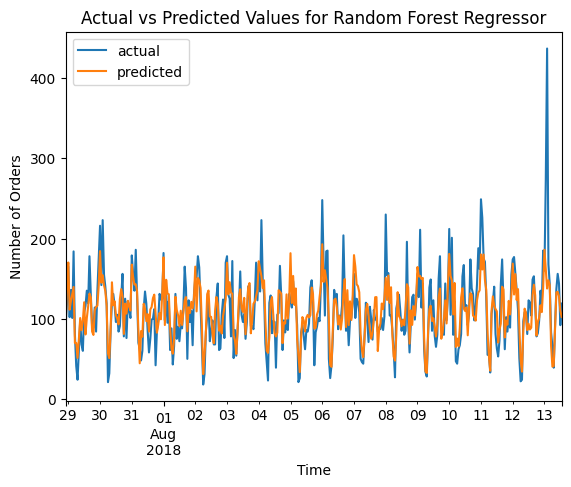

In [23]:
# Plot actual vs. predicted values for the random forest regressor

predict_valid = pd.Series(model.predict(features_valid), index=target_valid.index)
plot_data = pd.DataFrame({'actual': target_valid, 'predicted': predict_valid})

plot_data.plot()
plt.title("Actual vs Predicted Values for Random Forest Regressor")
plt.xlabel("Time")
plt.ylabel("Number of Orders")
plt.show()

I followed the same procedure to find the most predictive features for a random forest regressor model as I did for the linear regression model. The best performing version (RMSE = 29.48) had calendar features (month, day, hour, and day of the week), 240 lag features, and a rolling mean window of 24. A plot of feature importance revealed plateaus around 0.01 and 0.03. I retained 13 features with importance greater than 0.0031, including hour, rolling mean, and various lags (at 1, 2, 7, 8, 24, 48, 72, 96, 120, 168, 216). The model performed well with an RMSE of 29.48, essentially the same as the full model with 240 lags. 

I trained and tuned random forest models using RandomizedSearchCV and TimeSeriesSplit to optimize values for the hyperparameters n_estimators and max_depth. The best scoring model during tuning had n_estimators = 50, max_depth = 10, and RMSE = 21.38. More estimators generally hurt performance and scores plateaued after a max depth of 25. That optimal model performed well on my validation set with an RMSE of 29.74. RandomizedSearchCV produced better scores because it averaged over multiple validation folds. The predicted vs. actual plot also showed good performance. 

In [24]:
# Tune ARIMA hyperparameters
# Restrict and simplify the search to avoid kernel crashes

data = df_train.copy()
train, valid = train_test_split(data, shuffle=False, test_size=0.1)

model = auto_arima(
    train,
    seasonal=True,
    m=24,
    scoring="mse",
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=1,
    start_Q=0, max_Q=0, 
    trace=True,
    max_order=5,
    maxiter=20,
    approximation=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=35505.914, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=34098.501, Time=9.49 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=34973.765, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=35503.914, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=35134.612, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=34818.030, Time=5.57 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=33892.123, Time=14.99 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=35070.753, Time=0.47 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=33349.748, Time=24.76 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=17.51 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=inf, Time=26.14 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=33381.867, Time=22.06 sec
 ARIMA(2,1,1)(1,0,0)[24]             : AIC=inf, Time=10.02 sec

Best model:  ARIMA(2,1

ARIMA RMSE = 46.890404290702804

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 3576
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 24)   Log Likelihood              -16668.874
Date:                             Tue, 11 Mar 2025   AIC                          33349.748
Time:                                     01:54:45   BIC                          33386.839
Sample:                                 03-01-2018   HQIC                         33362.971
                                      - 07-27-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.010      0.396      0.692      -0.015       

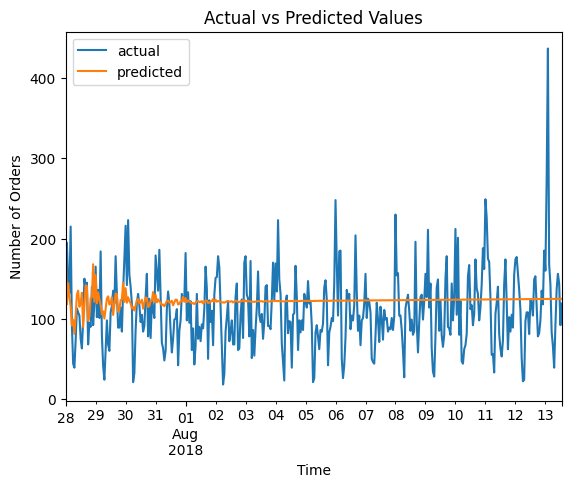

In [25]:
# Print and plot ARIMA model results

predictions = model.predict(len(valid))

print('ARIMA RMSE =', mean_squared_error(valid, predictions) ** 0.5)
print()
print(model.summary())

plot_data = pd.DataFrame({'actual': valid.squeeze(), 'predicted': predictions})

plot_data.plot()
plt.title("Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Number of Orders")
plt.show()

I used the auto_arima algorithm to optimize hyperparameters (p, d, q, P, D, Q) for an ARIMA model. I specified a one day seasonal period (m = 24) based on earlier analyses and restricted the maximum hyperparameter values to p = 2, q = 2, P = 1, and Q = 0 due to trouble with the kernel crashing. The best scoring model (RMSE = 46.89) had the configuration p = 2, d = 1, q = 1, P = 1, D = 0, Q = 0. The plot of predicted vs. actual values showed a poor model that essentially converged to a constant model, capturing the average but ignoring seasonality past the first few days. 

The absence of discernable seasonality in the predictions is puzzling because the model ostensibly incorporated it with a period of 24. I think the simplicity of the model with very small order hyperparameters (P and Q <= 2) prevented it from adequately accounting for seasonality. More complex models would probably perform better, but I could not get them to run without crashing the kernel. It is also interesting that auto_arima decided to employ differencing (d = 1) despite the time series being stationary according to the Dickey-Fuller unit root test. The algorithm must have determined that predictions were improved with differencing. Perhaps it was trying to address seasonality since it could not effectively model it. 

## Testing

In [26]:
# Test the optimized linear regression model

data_train = make_features(df_train, 240, 1)
data_test = make_features(df_test, 240, 1)
data_train = data_train[retained_features_LR].dropna()
data_test = data_test[retained_features_LR].dropna()

features_train = data_train.drop('num_orders', axis=1)
features_test = data_test.drop('num_orders', axis=1)
target_train = data_train['num_orders']
target_test = data_test['num_orders']

model = LinearRegression()
model.fit(features_train, target_train)

predict_train = pd.Series(model.predict(features_train))
predict_test = pd.Series(model.predict(features_test))
rmse_train = mean_squared_error(target_train, predict_train) ** 0.5
rmse_test = mean_squared_error(target_test, predict_test) ** 0.5

print('Linear Regression Model')
print(f"Training RMSE = {rmse_train:.02f}, Testing RMSE = {rmse_test:.02f}")

Linear Regression Model
Training RMSE = 21.35, Testing RMSE = 36.10


In [27]:
# Test the optimized random forest regressor model

data_train = make_features(df_train, 240, 1)
data_test = make_features(df_test, 240, 1)
data_train = data_train[retained_features_RF].dropna()
data_test = data_test[retained_features_RF].dropna()

features_train = data_train.drop('num_orders', axis=1)
features_test = data_test.drop('num_orders', axis=1)
target_train = data_train['num_orders']
target_test = data_test['num_orders']

model = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=10)
model.fit(features_train, target_train)

predict_train = pd.Series(model.predict(features_train))
predict_test = pd.Series(model.predict(features_test))
rmse_train = mean_squared_error(target_train, predict_train) ** 0.5
rmse_test = mean_squared_error(target_test, predict_test) ** 0.5

print('Random Forest Regressor Model')
print(f"Training RMSE = {rmse_train:.02f}, Testing RMSE = {rmse_test:.02f}")

Random Forest Regressor Model
Training RMSE = 13.39, Testing RMSE = 41.52


In [28]:
# Test the optimized ARIMA model

model = ARIMA(df_train, order=(2, 1, 1), seasonal_order=(1, 0, 0, 24), enforce_invertibility=False)
model = model.fit()

predict_train = model.predict(start=df_train.index[0], end=df_train.index[-1])
predict_test = model.forecast(steps=len(df_test))

rmse_train = mean_squared_error(df_train, predict_train) ** 0.5
rmse_test = mean_squared_error(df_test, predict_test) ** 0.5

print('ARIMA Model')
print(f"Training RMSE = {rmse_train:.02f}, Testing RMSE = {rmse_test:.02f}")

ARIMA Model
Training RMSE = 26.86, Testing RMSE = 63.27


I trained the final models with the full training set and tested them against the testing set. Training scores were reasonable, with the random forest regressor model (RMSE = 13.39) outperforming the linear regression model (RMSE = 21.35) and both outperforming the ARIMA model (RMSE = 26.86). The testing scores, on the other hand, were much worse. The linear regression model (RMSE = 36.10) and the random forest regressor model (RMSE = 41.52) handily beat the project threshold (RMSE < 48), but the ARIMA model failed to qualify (RMSE = 63.27).

As revealed by plots during exploratory data analysis, the last month of the time series (August) differs somewhat from earlier data. It trends higher and has greater variability. That largely explains the relatively poor performance of all models on the testing set. To some extent, this is an unavoidable consequence of forecasting later data from earlier data. If something changes toward the end of the time series, the training data cannot anticipate it. In this case, maybe the shift in August was a fluke or maybe it represents a fundamental change in taxi demand. I cannot determine that without more data. Either way, the linear regression and random forest regressor models offer adequate performance for the purposes of this project. 

## Conclusion

The purpose of this project was to forecast the number of hourly taxi orders based on historical data from the Sweet Lift Taxi company. The data were appropriate to the project after resampling to one-hour intervals. They showed an increasing trend, a seasonal component at the scale of one day, and autocorrelations spiking at intervals of 24 hours. The time series was also stationary (p < 0.05). 

I trained and tuned a linear regression model on features created from the time series, including calendar features, lag features, and rolling mean. After testing several specifications, I retained only the most important features as measured by coefficient size. They included month, day of week, day, hour, and various lags. The final linear regression model performed well with an RMSE of 29.01. 

Next, I trained and tuned a random forest regressor model on features created from the time series using the same procedure as before. The most important features included hour, rolling mean (with a 24-step window), and various lags. I also optimized hyperparameters, finding a reasonable balance of performance and complexity with 50 estimators, max_depth of 10, and an RMSE of 29.74. 

Finally, I trained and tuned an ARIMA model. I kept the hyperparameter search simple to avoid problems with the kernel crashing and assumed seasonality with a period of one day. The best scoring model had hyperparameters p = 2, d = 1, q = 1, P = 1, D = 0, Q = 0, and an RMSE of 46.89. A plot of predicted vs. actual values showed that the model failed to account for seasonality beyond the first few days, quickly collapsing to a constant model. That explains why it scored so much worse than the other models. Unfortunately, I could not get models with stronger seasonality to run without crashing.

All three optimized models were trained and tested on the full training and testing data sets. The test performance was disappointing, though the linear regression (RMSE = 36.10) and random forest regressor (RMSE = 41.52) models performed much better than the ARIMA model (RMSE = 63.27). I suspect the more robust lag terms included in the linear regression model (ranging from two hours to nine days) captured the seasonal component of the data better than the relatively simple ARIMA model. The weak test performance for all models stems from the last month of the time series (comprising the test set) departing noticeably from earlier data by exhibiting a greater mean and dispersion. Without more data, I cannot tell whether that difference represented an aberration or a fundamental shift in taxi demand. More research will be needed to address that. 

In the end, the linear regression model was the best, outperforming the others and easily beating the project threshold RMSE score of 48. It should serve the Sweet Lift Taxi company well for predicting hourly taxi demand at airports. 

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48